<a href="https://colab.research.google.com/github/IciaCarroBarallobre/AdventOfCode/blob/main/notebooks/%5Bv3%5D_Models%2C_train%2C_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Models, train e test





 ## Drive 

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


## Hiperparametros

In [2]:
#################    DATASET    ##############################
ROOT = '/content/drive/My Drive/TFG/'
ROOT_DATA = ROOT + 'data/'
ROOT_DATASETS = ROOT_DATA +'datasets/'
DATASET = 'subrolldataset'
OCT_DEVICE = 'SPECTRALIS'
CLASS = "SRD" # DME - DRT SRD CME
LABELS_CSV = "/info.csv" # "/info.csv"


################     MODEL    ##################################
MODEL_STR = 'Densenet161' 
OPTIM, LR  = 'Adam', 0.001
DEBUG = 1
EPOCHS = 200
PATIENCE = 20
BATCH = 16 # More than 16, cuda out of memory

## Imports 

In [3]:
import math
import os
import itertools
import numpy as np
import pandas as pd
import random 
import seaborn as sns

import torchvision
from torchvision import  models, transforms

import torch 
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import KFold

from PIL import Image 
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sn

## Dataset 


### <strong> OCTDataset:  </strong> Subclase de [dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)


**Dataset** é unha clase abstracta que representa a un conxunto de  **samples**. Un **sample** é unha **dupla** (input,label). 

As subclases de dataset poden sobrescribir as seguintes funcións:

*   *__getitem __(self,idx)* [OBL]: Obten un sample para unha  determinada clave  *idx*. 
*   *__len __ ()*[OPT]: Devolve o tamaño do conxunto de datos.


In [4]:
class OCTDataset(Dataset):

    def __init__(self, root, device = None,transform=None):
        self.root = root
        self.transform = transform
        self.device = device
        self.annotations = pd.read_csv(root+"/info.csv") 

        if self.device is not None:
          self.annotations = (self.annotations [self.annotations ["device"] == device]).reset_index(drop=True)


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,idx):
        image = Image.open(self.annotations["root"][idx] ).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        cme = self.annotations["CME"][idx]
        srd = self.annotations["SRD"][idx]
        drt = self.annotations["DRT"][idx]

        label = np.array([cme,srd,drt])
        name =  self.annotations["name"][idx] 
        
        return image, label, name #sample

    def info(self):
      return self.annotations

### **DataLoader**: Dataset to Iterable

Para poder iterar sobre un dataset necesitamos un [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).  




In [5]:
class KFolds():

  def __init__ (self, root_dataset_dir, n_folds):
    self.to_return = 0
    self.n_folds = n_folds
    self.root =  root_dataset_dir
    image_transforms =  transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.RandomHorizontalFlip(p = 0.5), # Poden aparecer patrones en calquer dir
        transforms.ToTensor() #Os anteriores traballan con PIL, non con tensores
        ])

    self.dataset = OCTDataset(root_dataset_dir, device=OCT_DEVICE, transform=image_transforms)
    self.folds = self.random_split_by_idxs_in_folds(self.dataset, self.n_folds)  


  def get_dataloaders(self):
      val_fold_idx, test_fold_idx =  (1 +  self.to_return)  % self.n_folds, self.to_return
      train_fold_idx = list(set(range(0, self.n_folds)) - set([val_fold_idx]) - set([test_fold_idx]))
           
      indeces_train = []
      for i in train_fold_idx:
        indeces_train = indeces_train + self.folds[i]


      train_set = Subset(self.dataset, indices = indeces_train  )
      val_set = Subset(self.dataset, indices = self.folds[val_fold_idx])
      test_set = Subset(self.dataset, indices = self.folds[val_fold_idx])

      data_generator = {'train': train_set, 'val': val_set, 'test': test_set}

      print("Folds - train ", train_fold_idx, "(",len(train_set), ")",
            "val ",val_fold_idx, " (",len(val_set),") test ",test_fold_idx,
            " (", len(test_set), ") \n")

      self.to_return = (1 +  self.to_return)  % self.n_folds

      return {k: DataLoader(data_generator[k], batch_size=BATCH, shuffle= True) 
      for k in ['train', 'val','test']}
      


  def random_split_by_idxs_in_folds(self, dataset, n_folds):
      
    df = dataset.info()
    df_ids = df.groupby(["id"]).count()["root"].to_frame()
    df_ids = df_ids.sample(frac=1)

    n_images_fold = int(len(df_ids)/n_folds)
    folds = []
    inis = list(range(0, len(df_ids), n_images_fold ))[0:-1]
    fins = [i + n_images_fold if i != inis[-1] else len(df_ids) for i in inis]

    for ini, fin in zip(inis, fins):
      ids_fold = list(df_ids[ini:fin].index)
      folds.append(list(df[df.id.isin(ids_fold)].index))

    return folds


## Train && Test

### EarlyStopping

In [6]:
class EarlyStopping:
    def __init__(self, patience, delta=0):
            
        self.patience = patience # Canto tempo esperar despois do mellor loss en val.
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta # Cambio minimo para contabilizar  
        self.model = model

    def __call__(self, val_loss, model):
        score =- val_loss
        if self.best_score is None:
            self.best_score = score
            self.model = model
        elif score < self.best_score + self.delta:
            self.counter += 1
            if DEBUG > 1:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.model = model
            self.counter = 0

    def save_checkpoint(self, path):    # Saves model when validation loss decrease.
        torch.save(model.state_dict(),path)

### Train && Test

In [7]:
########### Load Bar
def print_bar(now, maximum, max_length = 20):
    done = now/maximum
    print("\r"+round(done*max_length)*"█"+round(max_length*(1-done))*"░"+" "+str(round(done*100,2))+"% ", end='')

In [8]:
def count_sucesses(preds, labels, threshold):
  preds[preds >= threshold] = 1
  preds[preds < threshold] = 0
  return torch.sum(labels == preds, -2)

In [9]:
def train_model(device, model, data_loaders, criterion, optimizer, epochs = 50):
    
    early_stopping = EarlyStopping(patience=PATIENCE)
    train_loss, val_loss, acc_train, acc_val = [], [], [], []

    for epoch in range(epochs):
        print_bar(epoch+1, epochs)
        for phase in ['train','val']:
            model.train() if phase == 'train' else model.eval()
            results = torch.Tensor([0,0,0]).to(device)
            running_loss = torch.Tensor([0,0,0]).to(device)

            for inputs, labels, _  in data_loaders[phase]: 
                inputs, labels = inputs.to(device), labels.to(device)       
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):             # We don't want calculte gradients when we're val 
                    preds = torch.sigmoid(model(inputs))               # map outputs to range of 0-1
                    loss = criterion(preds, labels.type(torch.float))
                    loss = loss.sum(-2)
                    if phase == 'train':
                        loss.backward(torch.ones_like(loss))
                        optimizer.step() 
                    
                    results = count_sucesses(preds, labels, 0.5 ) + results
                    running_loss = loss + running_loss   
            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = results / len(data_loaders[phase].dataset)

            if phase == "train":
                train_loss.append(epoch_loss)
                acc_train.append(epoch_acc)
                
            elif phase == "val":
                val_loss.append(epoch_loss)
                acc_val.append(epoch_acc)
                early_stopping(epoch_loss.mean(), model)
                if early_stopping.early_stop:
                    return train_loss, val_loss, epoch, acc_train,acc_val, early_stopping
                                    
    return train_loss, val_loss, epochs, acc_train,acc_val, None

In [10]:
def test(device, model, data_loaders, threshold):
  
    model.eval()
    labels, preds = np.array([[]]), np.array([])
    for inputs_batch, labels_batch, _ in data_loaders["test"]:
        inputs_batch,labels_batch = inputs_batch.to(device),labels_batch.to(device)
        preds_batch = torch.sigmoid(model(inputs_batch))
        preds = np.append(preds, preds_batch.cpu().detach().numpy())
        labels = np.append(labels, labels_batch.cpu().detach().numpy())
    
    preds_without_thresholding = preds.copy().reshape(int(len(preds)/3),3)
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0

    preds = preds.reshape(int(len(preds)/3),3)
    labels = labels.reshape(int(len(labels)/3),3)

    return preds, labels, preds_without_thresholding

## Graph of test and train aux

In [11]:
def graph_train_val_enf(model_name,train_loss,valid_loss, early, acc_train,acc_val, enfermidade):

    length = len(acc_val)
    idx = {"CME" : 0, "SRD": 1, "DRT":2}
    idx = idx[enfermidade] 

    plt.subplot(211)
    val_acc, train_acc = [x[idx] for x in acc_val],  [x[idx] for x in acc_train]    
    plt.plot(range(0,length+1), [0]+val_acc, label='Val Acc', color = "tab:orange")
    plt.plot(range(0,length+1), [0]+train_acc, label='Train Acc', color = "tab:blue")

    if(early):
        plt.axvline(len(acc_val)-PATIENCE, 0, 1, label='Early stopping', color="r")

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(model_name+ " "+ enfermidade)
    plt.ylim(0.6, 1)
    plt.legend()

    plt.subplot(212)
    val_loss, train_loss = [x[idx] for x in valid_loss], [x[idx] for x in train_loss]    
    plt.plot(range(0,length+1), [1]+val_loss, label='Val Loss', color = "tab:orange")
    plt.plot(range(0,length+1), [1]+train_loss, label='Train Loss', color = "tab:blue")

    if(early):
        plt.axvline(len(acc_val)-PATIENCE, 0, 1, label='Early stopping', color="r")

    plt.xlabel('Epoch')
    plt.ylabel(' Loss')
    plt.ylim(0, 0.6)
    plt.legend()
    plt.show()

def graph_train_val(MODEL_STR,train_loss, valid_loss, early_stop, acc_train,acc_val):
    graph_train_val_enf(MODEL_STR,train_loss, valid_loss, early_stop, acc_train,acc_val, "CME")
    graph_train_val_enf(MODEL_STR,train_loss, valid_loss, early_stop, acc_train,acc_val, "SRD") 
    graph_train_val_enf(MODEL_STR,train_loss, valid_loss, early_stop, acc_train,acc_val, "DRT")   

In [12]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

def confusion_matrix_plot(labels, preds):

  i = 0
  enfermidades = ["CME","SRD","DRT"]
  cms = multilabel_confusion_matrix(labels, preds)

  fig, ax = plt.subplots(1, 3, figsize=(13, 5))
      
  for axes, cfs_matrix, label in zip(ax.flatten(), cms, enfermidades):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

    tn, fp,  fn, tp  = cfs_matrix[0][0], cfs_matrix[0][1], cfs_matrix[1][0], cfs_matrix[1][1]
    txt_sen = "Sensibilidad  "+ str(np.round(tp/(tp+fn),3))
    txt_esp = "Especificidad " + str(np.round(tn/(tn+fp),3))

    axes.text(0.2, -.25, txt_esp, horizontalalignment='center', verticalalignment='center', transform=axes.transAxes)
    axes.text(0.2, -.3, txt_sen, horizontalalignment='center', verticalalignment='center', transform=axes.transAxes)

  fig.tight_layout()
  plt.show()
  return  cms                 

In [ ]:
import ast

def all_train_graphics_kfold(root, id,  grid="True", param= "acc", enfermedad = "SRD"): 
  df = pd.read_csv(root)
  df = df[df["id"]==id]
  indices = {"CME" : 0, "SRD": 1, "DRT":2}
  idx = indices[enfermedad]
  df_enf = pd.DataFrame([])

  if param == "loss":
    param_ini = 1
  else:
    param_ini=0
  
  for idxs, row in df.iterrows():
     a = [e[idx] for e in ast.literal_eval(row["val_"+param])]
     for i in range(0, len(a)):
       df_enf = df_enf.append({"epoch": int(i) , "val_"+param: float(a[i]) },  ignore_index=True)
  
  mean = df_enf.groupby("epoch").mean()["val_"+param].tolist()
  std = df_enf.groupby("epoch").std()["val_"+param].tolist()
  std_up = [x + y for x, y in zip(mean, std)]
  std_down = [x - y for x, y in zip(mean, std)]

  plt.fill_between(range(len(std_up)+1), [param_ini]+std_up, [param_ini]+std_down, label = "Std val", alpha = .25, color= "b")
  plt.plot(range(len(mean)+1), [param_ini]+ mean, label = "Mean val", color = "tab:blue")   


  for idxs, row in df.iterrows():
     a = [e[idx] for e in ast.literal_eval(row["train_"+param])]
     for i in range(0, len(a)):
       df_enf = df_enf.append({"epoch": int(i) , "train_"+param: float(a[i]) },  ignore_index=True)
  
  mean = df_enf.groupby("epoch").mean()["train_"+param].tolist()
  std = df_enf.groupby("epoch").std()["train_"+param].tolist()
  std_up = [x + y for x, y in zip(mean, std)]
  std_down = [x - y for x, y in zip(mean, std)]

  plt.fill_between(range(len(std_up)+1), [param_ini]+std_up, [param_ini]+std_down, label = "Std train", alpha = .25, color= "g")
  plt.plot(range(len(mean)+1), [param_ini]+ mean, label = "Mean train", color = "tab:green")   

  plt.ylabel(param)
  if param == "acc": 
    plt.ylim(0.6, 1.05)
  elif param =="loss":
    plt.ylim(0.0, 0.75)



  plt.grid(grid)
  plt.title(enfermedad)
  plt.legend()
  plt.show()  

## Main



### Funciones auxiliares

In [13]:
def select_network(name, pretrained):
    if 'Resnet50'==name: 
      return models.resnet50(pretrained=pretrained)
    elif 'Resnet101'==name: 
      return models.resnet101(pretrained=pretrained)
    elif 'VGG16'==name: 
      return models.vgg16(pretrained=pretrained)
    elif 'VGG19'==name: 
      return models.vgg19(pretrained=pretrained)
    elif 'Densenet161'==name:
      return models.densenet161(pretrained=pretrained)
    
def select_optimizer(model, opt, lr): 
  if opt == 'Adam': 
      return optim.Adam(model.parameters(), lr=lr)
  else:
      raise "NotImplementYet"

In [14]:
def set_model(model, string, n_classes = 2): 
  
  if ('VGG' == string[:3]):
    model.classifier[-1] = nn.Linear(4096,n_classes, bias = True)   
  elif ('Densenet' == string[:8]):
    model.classifier = nn.Linear(model.classifier.in_features, n_classes, bias = True)  
  else:
    model.fc = nn.Linear(model.fc.in_features, n_classes, bias = True) 

  return model

In [15]:
def sen(cm):
    tn, fp,  fn, tp  = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return np.round(tp/(tp+fn),3)
    
def esp(cm):    
    tn, fp,  fn, tp  = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return  np.round(tn/(tn+fp),3)

### Main a ejecutar

In [16]:
try:
  df = pd.read_csv(ROOT_DATA+"results/MULTILABEL/v1/results.csv")
  id = len(df)

except FileNotFoundError:
  df = pd.DataFrame([]) 
  id = 0

In [17]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr  4 12:09:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Chosen device :", device)

folds = KFolds(ROOT_DATASETS+DATASET, 5)

for i in range(0,folds.n_folds):

  model = select_network(MODEL_STR, True)
  model = set_model(model, MODEL_STR, 3)
  model.to(device)

  for param in model.parameters():
      param.requires_grad = True  # Son entrenables = True
      
  criterion = nn.BCELoss(weight=None, reduction="none")
  optimizer = select_optimizer(model, opt = OPTIM, lr = LR)
  data_loaders = folds.get_dataloaders()
  ###### Train ######
  result_train = train_model(device = device, model = model, 
                            data_loaders = data_loaders, criterion = criterion, 
                            optimizer= optimizer, epochs = EPOCHS)

  train_loss, valid_loss, stop_epoch, acc_train, acc_val, early_stopping = result_train

  #graph_train_val(MODEL_STR,train_loss, valid_loss, early_stopping.early_stop, acc_train,acc_val)
  ###### Test ######

  preds, labels, preds_without_threshold  = test(device, model, data_loaders, 0.5)
  #cms = confusion_matrix_plot(labels, preds)
  cms = multilabel_confusion_matrix(labels, preds)
  cm_cme, cm_srd, cm_drt = cms[0], cms[1], cms[2]
  print([list(e.detach().cpu().numpy()) for e in train_loss], type(train_loss))
  row = {
      'id': id,
      'fold': i, 
      'EarlyStopping': str(stop_epoch)+"/"+str(EPOCHS), 
      'train_acc': [list(e.detach().cpu().numpy()) for e in acc_train],
      'val_acc': [list(e.detach().cpu().numpy()) for e in acc_val],
      'train_loss': [list(e.detach().cpu().numpy()) for e in train_loss],
      'val_loss':  [list(e.detach().cpu().numpy()) for e in valid_loss],
      'especificidad_CME': esp (cm_cme),
      'especificidad_SRD': esp (cm_srd),
      'especificidad_DRT': esp (cm_drt),
      'sensibilidad_CME':  sen (cm_cme),
      'sensibilidad_SRD':  sen (cm_srd),
      'sensibilidad_DRT': sen (cm_drt),
      'lr': LR, 'optim': OPTIM, 
      'model': MODEL_STR, 'batch_size': BATCH
  }
  df = df.append(row, ignore_index=True)

df.to_csv(ROOT_DATA+"results/MULTILABEL/v1/results.csv", index=False)    

Chosen device : cuda:0


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth



Folds - train  [2, 3, 4] ( 1236 ) val  1  ( 366 ) test  0  ( 366 ) 

███░░░░░░░░░░░░░░░░░ 16.5% [[0.35733995, 0.1941886, 0.37431136], [0.28523016, 0.111993834, 0.30886948], [0.2728788, 0.11312364, 0.26864895], [0.23715557, 0.08773129, 0.25120166], [0.22174443, 0.06313787, 0.23656015], [0.21524249, 0.04350914, 0.2103655], [0.23999795, 0.07401346, 0.22025265], [0.21200894, 0.04534701, 0.19974536], [0.18139072, 0.03734603, 0.18418956], [0.16149938, 0.042311355, 0.18000798], [0.18915297, 0.049115323, 0.20207316], [0.15406187, 0.032332193, 0.18065746], [0.13245253, 0.018914072, 0.1591606], [0.13471548, 0.018679684, 0.15962963], [0.16344823, 0.019706482, 0.14657496], [0.1171047, 0.008730321, 0.12557863], [0.122883044, 0.012273878, 0.17536564], [0.09268991, 0.020307645, 0.15055715], [0.10345783, 0.01452829, 0.10769491], [0.11679486, 0.013468216, 0.1264068], [0.12903987, 0.014429871, 0.11742683], [0.06850222, 0.010271401, 0.104728974], [0.12386415, 0.010469049, 0.09466741], [0.123457864, 0.01

In [27]:
print("Especificidad ")
print(" DRT "+ str(np.round(df[(df["id"]==id)]['especificidad_DRT'].mean(),2)))
print(" CME "+ str(np.round(df[(df["id"]==id)]['especificidad_CME'].mean(),2)))
print(" SRD "+ str(np.round(df[(df["id"]==id)]['sensibilidad_SRD'].mean(),2)))

print("\nSensibilidad ")

print(" CME "+ str(np.round(df[(df["id"]==id)]['sensibilidad_CME'].mean(),2)))
print(" SRD "+ str(np.round(df[(df["id"]==id)]['sensibilidad_SRD'].mean(),2)))
print(" DRT "+ str(np.round(df[(df["id"]==id)]['sensibilidad_DRT'].mean(),2)))

Especificidad 
 DRT 0.91
 CME 0.94
 SRD 0.86

Sensibilidad 
 CME 0.9
 SRD 0.86
 DRT 0.88


## Graph KFOLD

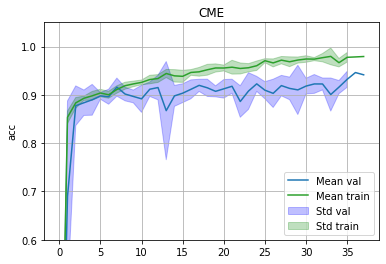

In [106]:
all_train_graphics_kfold(ROOT_DATA+"results/MULTILABEL/v1/results.csv", id, param = "acc", enfermedad="CME")